# Estimating 3D rotation parameters from 2D images

Part 1: generates and saves test images with various rotation axes and speeds. The images mimic "real" solid-body objects with some surface features that can be tracked.

Part 2: Takes tracks of the surface features (tracked using a multipoint_tracking.py) and uses them as input to a model that extracts the underlying rotation parameters. This is then compared to the "ground-truth" that was used to generate the images to assess the performance of the method.

In [151]:
import numpy as np
import cv2

R_sphere = 1 # Sphere radius
N = 10 # No:of test points generated
omega = 0.0255 # Rotation speed is s^-1
# p = np.array( [-0.61291544,  0.79014699, -0.00154731], dtype = 'float32') # Orientation of rotation axis
p_orient = np.array( [0, 1, 1], dtype = 'float32') # Orientation of rotation axis


p = p_orient/np.linalg.norm(p_orient)  # Unit vector

# Initial locations of the points
theta = np.random.uniform(0, 2*np.pi, N)
r = np.random.uniform(0,R_sphere,N)

x_init, z_init = r*np.cos(theta), r*np.sin(theta) 
y_init = (R_sphere**2 - x_init**2 - z_init**2)**(1/2)  # Only assuming points in the +ve y direction

r_init = np.stack((x_init, y_init, z_init))

np.shape(r_init)

(3, 10)

<IPython.core.display.Javascript object>


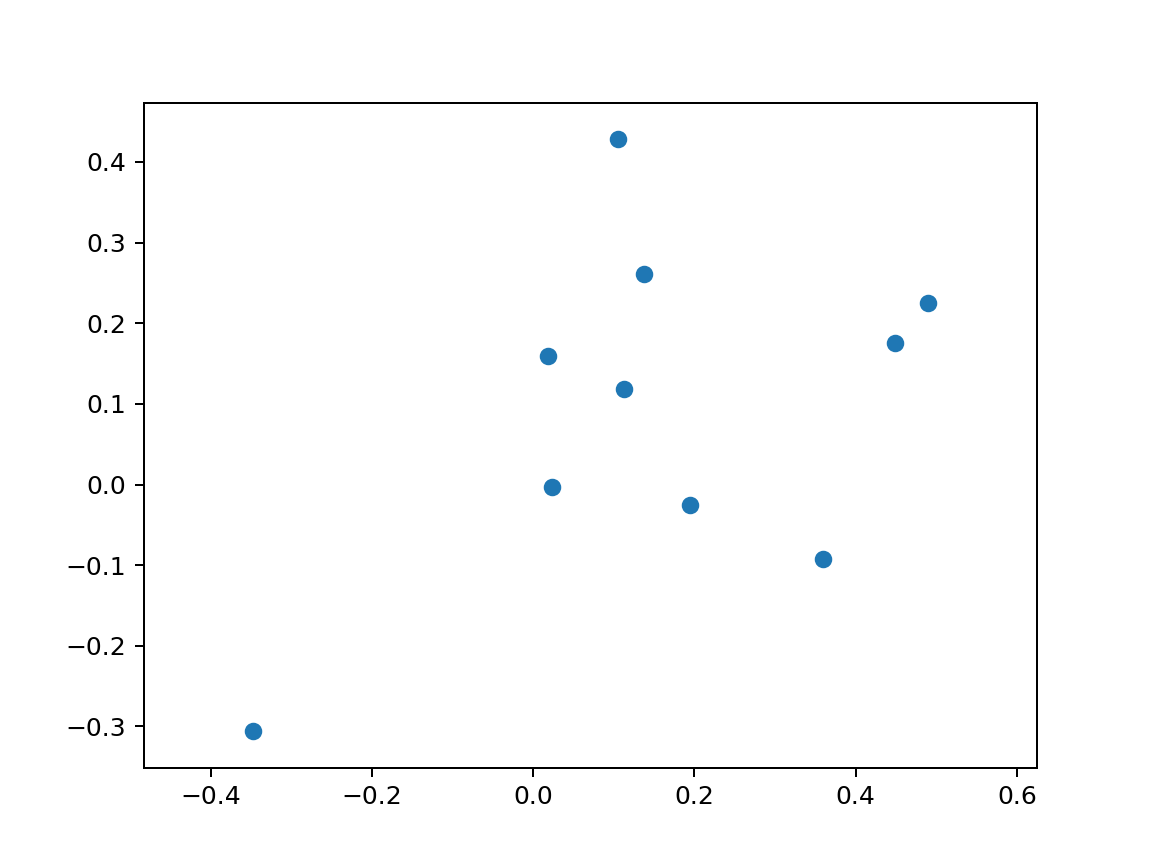

In [143]:
# Plot the initial distribution of points within the circle
import matplotlib.pyplot as plt
%matplotlib notebook
plt.figure()
plt.scatter(r_init[0,:], r_init[2,:])
ax = plt.gca()
circle1 = plt.Circle((0, 0), 1, fill= False, color='r')
ax.add_artist(circle1)
plt.axis('equal')
plt.show()

In [144]:
# Simulate the trajectory of points under solid-body rotation.
# using v = \omega \cross r

omega_vector = omega*p

v = np.cross(omega_vector, r_init, axisa = 0, axisb = 0)
v

array([[-0.01813441,  0.00351483, -0.00351483],
       [-0.01113886,  0.00881846, -0.00881846],
       [-0.021501  , -0.00625929,  0.00625929],
       [-0.01565066,  0.00202081, -0.00202081],
       [-0.01262998,  0.00809587, -0.00809587],
       [-0.01807481,  0.00043154, -0.00043154],
       [-0.01841443,  0.00648242, -0.00648242],
       [-0.01491643,  0.00033225, -0.00033225],
       [-0.00846975,  0.00190574, -0.00190574],
       [-0.01252218,  0.00247744, -0.00247744]])

<IPython.core.display.Javascript object>


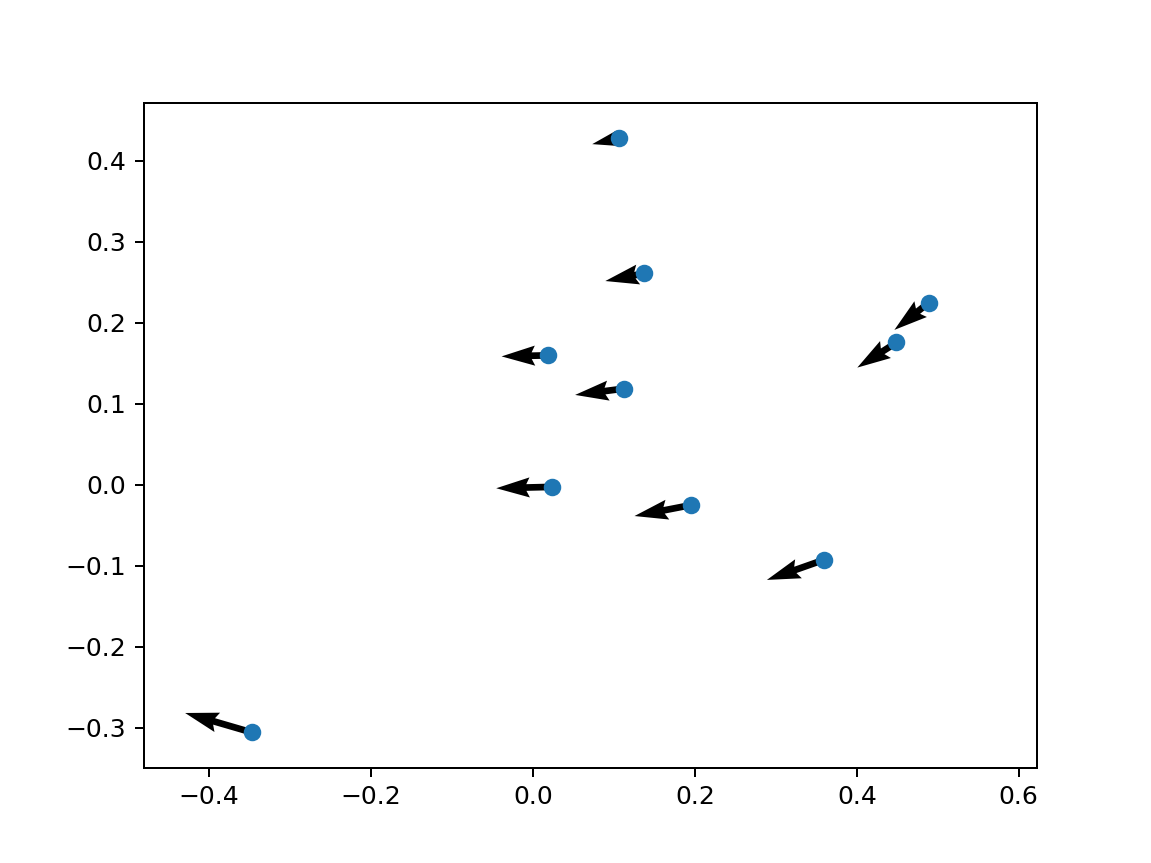

In [145]:
plt.figure()
plt.quiver(r_init[0,:], r_init[2,:], v[:,0], v[:,2])
plt.scatter(r_init[0,:], r_init[2,:])
ax = plt.gca()
circle1 = plt.Circle((0, 0), 1, fill= False, color='r')
ax.add_artist(circle1)
plt.axis('equal')
plt.show()

In [146]:
from scipy.spatial.transform import Rotation as R

r = R.from_rotvec(omega*p)

r.as_dcm

<bound method Rotation.as_dcm of <scipy.spatial.transform.rotation.Rotation object at 0x83e310b70>>

<IPython.core.display.Javascript object>


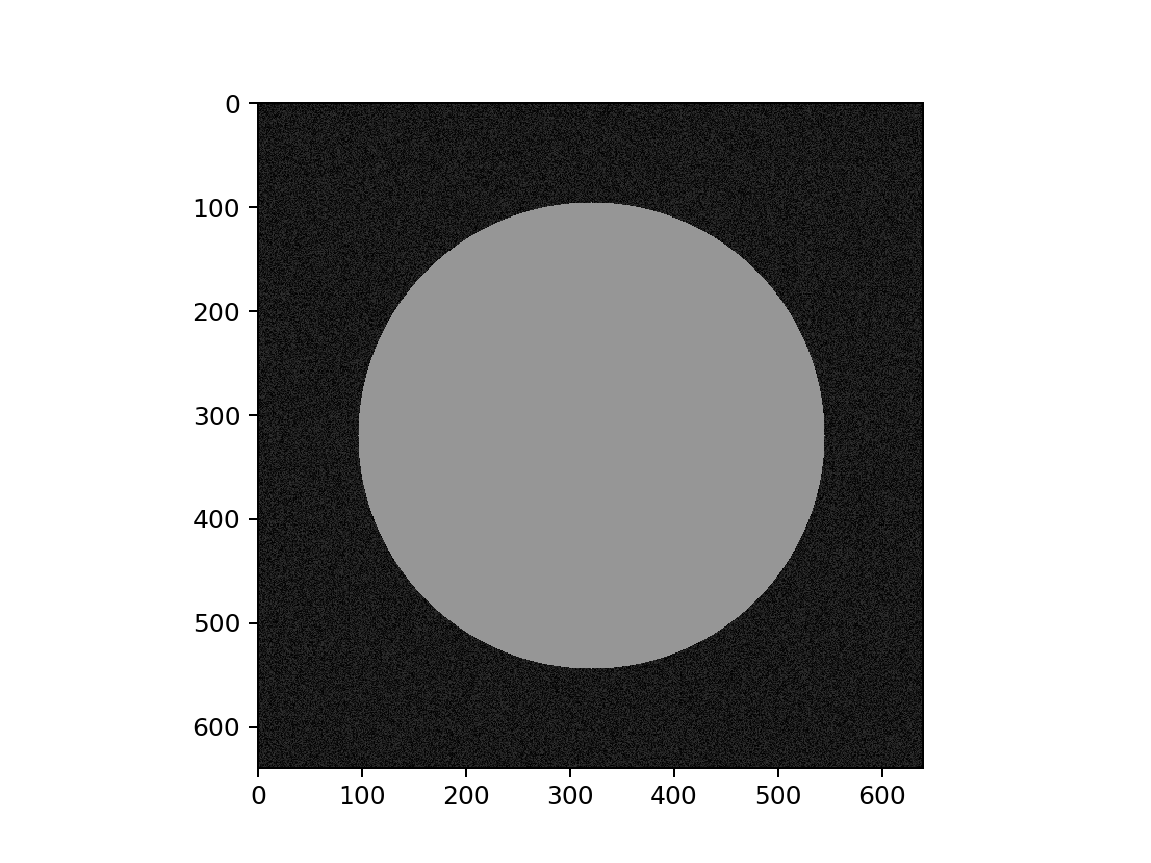

In [147]:
# Create a trajectory of surface points over time

N_timesteps = 50

# Create image canvas
image_size = (640, 640)
R_circle = int(0.7*image_size[0]/2)
center = (320, 320)

init_image = np.random.randint(50, size = (640,640), dtype = np.uint8)

cv2.circle(init_image, center, R_circle ,(150,0,0),-1)

plt.figure()
plt.imshow(init_image, cmap = 'gray', vmin = 0, vmax = 255)
plt.show()



In [148]:
# Make some test images with simulated surface features and their dynamics over time
import os
from datetime import datetime

# save_folder = 'C:/Users/Deepak/Dropbox/ActiveMassTransport_Vorticella_SinkingAggregates/RotationalAnalysis/test_images_' + datetime.now().strftime('%Y-%m-%d %H-%M')
# save_folder = '/Users/deepak/Dropbox/ActiveMassTransport_Vorticella_SinkingAggregates/RotationalAnalysis/FinalValidation/test_images_' + datetime.now().strftime('%Y-%m-%d %H-%M')
save_folder = '/Users/deepak/Dropbox/ActiveMassTransport_Vorticella_SinkingAggregates/RotationalAnalysis/FinalValidation/test_images_p_{}_{}_{}_omega_{}'.format(round(p_orient[0],1), round(p_orient[1],1), round(p_orient[2],1), omega) 

images_folder = os.path.join(save_folder, 'images')

if not os.path.exists(images_folder):
    os.makedirs(images_folder)
    
if(not os.path.exists(save_folder)):
    os.makedirs(save_folder)
    
    
prev_pos = r_init
curr_pos = np.zeros_like(prev_pos) 
curr_pos_array = np.zeros((3, N, N_timesteps))

for ii in range(N_timesteps):
    
    image = np.copy(init_image)
    # We need to transform to spherical coordinates to do this (otherwise, we will no longer be on the sphere)
    for jj in range(N):
        curr_pos[:,jj] = r.apply(prev_pos[:,jj])
        # Add some Gaussian noise to the positions
#         noise = (0.001)*np.random.randn(3)
        noise = 0
        curr_pos[:,jj] = curr_pos[:,jj] + noise
        curr_pos_array[:, jj, ii] = curr_pos[:, jj]
        feature_loc = (center[0] + int(R_circle*curr_pos[0,jj]), center[1] + int(R_circle*curr_pos[2,jj]))
        cv2.circle(image, feature_loc, int(0.01*image_size[0]),(225,0,0),-1)
    
    cv2.imwrite(os.path.join(images_folder, 'test_image_{:03d}.tif'.format(ii)), image)
#     plt.figure()
#     plt.imshow(image, cmap = 'gray', vmin = 0, vmax = 255)
#     plt.show()
        
    prev_pos = curr_pos
    
# Save the rotation rate and axis 
import pandas as pd

df = pd.DataFrame({'Omega':[omega], 'p_x':[p[0]], 'p_y':[p[1]], 'p_z':[p[2]]})

df.to_csv(os.path.join(save_folder,'RotationParameters.csv'))




In [149]:
# Save the trajectories of the test points
df_tracks = pd.DataFrame({'Time':[], 'Track ID':[], 'X':[], 'Y':[], 'Z':[]})

for jj in range(N):
    
    df_tracks = df_tracks.append(pd.DataFrame({'Time':range(N_timesteps), 'Track ID':int(jj), 'X':curr_pos_array[0,jj,:], 'Y':curr_pos_array[1,jj,:], 'Z':curr_pos_array[2,jj,:]}))
    
df_tracks
df_tracks.to_csv(os.path.join(save_folder,'TestPoint_Tracks.csv'))


# Apply the Rotation detection model on the trajectories 
Extract the rotation vector and rotation speed

In [4]:
import numpy as np
import cv2
import pandas as pd
import os
from datetime import datetime

In [53]:
# Load the trajectories of tracked features
# data_folder = '/Users/deepak/Dropbox/ActiveMassTransport_Vorticella_SinkingAggregates/RotationalAnalysis/FinalValidation/test_images_p_1.0_0.0_0.0_omega_0.0255'
# data_folder = '/Users/deepak/Dropbox/ActiveMassTransport_Vorticella_SinkingAggregates/RotationalAnalysis/FinalValidation/test_images_p_0.7_0.7_0.0_omega_0.0255'
# data_folder = '/Users/deepak/Dropbox/ActiveMassTransport_Vorticella_SinkingAggregates/RotationalAnalysis/FinalValidation/test_images_p_1.0_1.0_1.0_omega_0.0255'
# data_folder = '/Users/deepak/Dropbox/ActiveMassTransport_Vorticella_SinkingAggregates/RotationalAnalysis/test_images_2020-12-08 01-32'
data_folder = '/Users/deepak/Dropbox/ActiveMassTransport_Vorticella_SinkingAggregates/RotationalAnalysis/test_images_2020-12-13 19-09'
track_folder = 'RotationAnalysisTracks'
track_file = 'RotationTrack.csv'

df = pd.read_csv(os.path.join(data_folder, track_folder, track_file))

nTracks = int(max(df['feature ID']+1))
df_tracks = {ii : df.loc[df['feature ID']==ii] for ii in range(nTracks)}

time_vect = np.array(df_tracks[0]['Time'])
print(time_vect)
Radius = 1


[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]


In [54]:
# Load the "Ground Truth" rotation parameters
df_rotation = pd.read_csv(os.path.join(data_folder, 'RotationParameters.csv'))

omega_true = df_rotation['Omega'][0]
p_x_true, p_y_true, p_z_true = df_rotation['p_x'][0], df_rotation['p_y'][0], df_rotation['p_z'][0]

orient_vect_true = np.array([p_x_true, p_y_true, p_z_true])

omega_vect_true = omega_true*orient_vect_true

print('Rotation speed: {}'.format(omega_true))
print('Rotation axis: {}, {}, {}'.format(p_x_true, p_y_true, p_z_true))


Rotation speed: 0.0255
Rotation axis: -0.6129154562950134, 0.7901470065116882, -0.001547310035675764


# Filter the tracks to smooth pixel shift noise

In [55]:
# Time windows for smoothing and velocity estimation
# window_size = 2 # should be even
# Choose a window-size based on a time-interval 
time_window = 3 # Time window over which we calculate the velocity in seconds

delta_t_avg = np.nanmean(time_vect[1:]-time_vect[:-1])

print('Mean time interval: {} s'.format(delta_t_avg))

window_size = int(time_window/delta_t_avg)

# make the window-size an even integer
if window_size%2 !=0:
    window_size+=1
    
print('Chosen window size for velocity calculation: {}'.format(window_size))

sphere_centroid_X_filtered = None
sphere_centroid_Z_filtered = None

feature_centroid_X_filtered = {}
feature_centroid_Z_filtered = {}

for ii in range(nTracks):
    
    sphere_centroid_X_filtered = np.array(df_tracks[ii].loc[:,'sphere centroid X'].rolling(window = window_size, center = True).mean())
    sphere_centroid_Z_filtered = np.array(df_tracks[ii].loc[:,'sphere centroid Z'].rolling(window = window_size, center = True).mean())
    
    feature_centroid_X_filtered[ii] = np.array(df_tracks[ii].loc[:,'feature centroid X'].rolling(window = window_size, center = True).mean())
    feature_centroid_Z_filtered[ii] = np.array(df_tracks[ii].loc[:,'feature centroid Z'].rolling(window = window_size, center = True).mean())
    
    
#     df_tracks[ii]['feature centroid X'] = df_tracks[ii]['feature centroid X'].rolling(window = window_size).mean()
#     df_tracks[ii]['feature centroid Z'] = df_tracks[ii]['feature centroid Z'].rolling(window = window_size).mean()

nan_mask = np.logical_not(np.isnan(sphere_centroid_X_filtered))

print(sphere_centroid_X_filtered)

print(df_tracks[0]['sphere centroid X'])
print(nan_mask)

# Remove the boundary points that do not contribute to the moving average

image_centroids_x = {}
image_centroids_z = {}
centroids_x = {}
centroids_z = {}

# Choose a subset of the time-vect excluding the nan values
time_vect = time_vect[nan_mask]
nTimepoints = len(time_vect)

# Sphere centroid common to all tracks
sphere_centroids_x, sphere_centroids_z = sphere_centroid_X_filtered[nan_mask], sphere_centroid_Z_filtered[nan_mask]

for ii in range(nTracks):
    image_centroids_x[ii], image_centroids_z[ii] = feature_centroid_X_filtered[ii][nan_mask], feature_centroid_Z_filtered[ii][nan_mask]
   
print(time_vect)

Mean time interval: 1.0 s
Chosen window size for velocity calculation: 4
[  nan   nan 319.  318.5 318.5 318.5 318.5 318.5 318.5 318.5 318.5   nan]
0     320.0
1     319.0
2     318.0
3     319.0
4     318.0
5     319.0
6     318.0
7     319.0
8     318.0
9     319.0
10    318.0
11    319.0
Name: sphere centroid X, dtype: float64
[False False  True  True  True  True  True  True  True  True  True False]


## Get the centroid locations relative to the sphere center

In [57]:
for ii in range(nTracks):
    centroids_x[ii] = image_centroids_x[ii] - sphere_centroids_x
    centroids_z[ii] = image_centroids_z[ii] - sphere_centroids_z

print(centroids_z[2])

[-162.27395248 -165.65145874 -169.03222656 -172.41957092 -175.55697632
 -178.70980835 -181.62910843 -184.32110214 -187.00437927]


## Calculate centroid velocity over a suitable time-window for each track

In [58]:
R = 320

overlap = int(window_size/2)  # Max overlap = window_size -1
window_centers = np.array(range(int(window_size/2), nTimepoints-int(window_size/2), window_size - overlap))
nWindows = len(window_centers) # No:of time-windows over the entire track

window_edges = [[window_centers[ii] - int(window_size/2), window_centers[ii] + int(window_size/2)] for ii in range(nWindows)]
print(window_centers)
print(window_edges)

centroids_velocity_x = {ii: np.zeros(nWindows) for ii in range(nTracks)}
centroids_velocity_z = {ii: np.zeros(nWindows) for ii in range(nTracks)}
positions_center_x = {ii:np.zeros(nWindows) for ii in range(nTracks)} # Position of the features at the mid-point of the time-windows
positions_center_y = {ii:np.zeros(nWindows) for ii in range(nTracks)} # Position of the features at the mid-point of the time-windows
positions_center_z = {ii:np.zeros(nWindows) for ii in range(nTracks)} # # Position of the features at the mid-point of the time-windows

# Estimate the velocity of feature centroids (linear fit over the specified time window)
for index, center in enumerate(window_centers):
    
    # Create a sub-portion of the track containing N points
    for ii in range(nTracks):
        centroids_x_slice = centroids_x[ii][window_edges[index][0]:window_edges[index][1]]
        centroids_z_slice = centroids_z[ii][window_edges[index][0]:window_edges[index][1]]
        time_vect_slice = time_vect[window_edges[index][0]:window_edges[index][1]]

        poly_x = np.polyfit(time_vect_slice, centroids_x_slice, deg = 1)
        poly_z = np.polyfit(time_vect_slice, centroids_z_slice, deg = 1)

     

        centroids_velocity_x[ii][index] = poly_x[0]
        centroids_velocity_z[ii][index] = poly_z[0]
        
        positions_center_x[ii][index] = centroids_x[ii][center]
        positions_center_z[ii][index] = centroids_z[ii][center]
        positions_center_y[ii][index] = (R**2 - centroids_x[ii][center]**2 + centroids_z[ii][center]**2)**(1/2)
        
        # Calculate the true translational velocities based on the known angular velocity
        r_init = np.array([positions_center_x[ii][index], positions_center_y[ii][index], positions_center_z[ii][index]])
        

[2 4 6]
[[0, 4], [2, 6], [4, 8]]


## Perform a least-squares-fit based on the velocities of the tracked points

In [59]:

angular_velocity_fit = np.zeros((3, nWindows))
angular_velocity_fit_mag = np.zeros(nWindows)

for index in range(nWindows):
    
    # For each time instant build the matrix A and the data vector by looping over all the tracks
    matrix_A = np.zeros((2*nTracks, 3))
    data_vector_fit = np.zeros(2*nTracks)
    
    for ii in range(nTracks):
        r_x, r_y, r_z = positions_center_x[ii][index], positions_center_y[ii][index], positions_center_z[ii][index]

        matrix_A[2*ii,:] = [0, r_z, -r_y]
        matrix_A[2*ii +1, :] = [r_y, -r_x, 0]

        data_vector_fit[2*ii] = centroids_velocity_x[ii][index]
        data_vector_fit[2*ii+1] = centroids_velocity_z[ii][index]

#     print(matrix_A)
#     print(data_vector_fit)
    # Compute the least-squares solution using lin alg

    angular_velocity_fit[:, index] = np.matmul(np.linalg.pinv(matrix_A), data_vector_fit)
    
    angular_velocity_fit_mag[index] = np.sum(angular_velocity_fit[:, index]**2)**(1/2)
#     AT = matrix_A.transpose()
    
#     ATA_inv = np.linalg.inv(np.matmul(AT, matrix_A))
    
#     angular_velocity_fit[:, index] = np.matmul(np.matmul(ATA_inv, AT), data_vector_fit)
    
#     print(angular_velocity_fit)




## Analyze and plot the results from the fitting

In [19]:

plt.figure()
plt.plot(angular_velocity_fit_mag)
plt.show()

NameError: name 'plt' is not defined

In [20]:
# Relative error
print(omega_fit_mean)
print(omega_true)
rotation_mag_error = ((omega_fit_mean - omega_true)**2/omega_true**2)**(1/2)
print('Relative error in rotation speed: {}%'.format(rotation_mag_error*100))

0.02077876381589026
0.0255
Relative error in rotation speed: 18.51465170239113%


## Plot the "Actual" vs "Predicted" velocities of the tracked features